# LowLou Metric

In [ ]:
from setproctitle import setproctitle

setproctitle("LowLou metric")

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [ ]:
import pyvista as pv
import matplotlib.pyplot as plt

In [ ]:
b_vtk_path = '01_input/lowlou_256256256/b.vtk'
b_mesh = pv.read(b_vtk_path)
Nx, Ny, Nz = b_mesh.dimensions
b_mesh

StructuredGrid (0x7feb806a3b80)
  N Cells:      16581375
  N Points:     16777216
  X Bounds:     0.000e+00, 2.550e+02
  Y Bounds:     0.000e+00, 2.550e+02
  Z Bounds:     0.000e+00, 2.550e+02
  Dimensions:   256, 256, 256
  N Arrays:     2

In [ ]:
total_iter = 10000

In [ ]:
B_pinn_vtk_path = f'03_eval/lowlou_256256256/PINN/B_pinn_{total_iter}.vtk'
B_pinn_mesh = pv.read(B_pinn_vtk_path)
B_pinn_mesh

ImageData (0x7feb42316a40)
  N Cells:      16581375
  N Points:     16777216
  X Bounds:     0.000e+00, 2.550e+02
  Y Bounds:     0.000e+00, 2.550e+02
  Z Bounds:     0.000e+00, 2.550e+02
  Dimensions:   256, 256, 256
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

In [ ]:
B_spinn_vtk_path = f'03_eval/lowlou_256256256/SPINN/B_spinn_{total_iter}.vtk'
B_spinn_mesh = pv.read(B_spinn_vtk_path)
B_spinn_mesh

StructuredGrid (0x7feb42316da0)
  N Cells:      16581375
  N Points:     16777216
  X Bounds:     0.000e+00, 2.550e+02
  Y Bounds:     0.000e+00, 2.550e+02
  Z Bounds:     0.000e+00, 2.550e+02
  Dimensions:   256, 256, 256
  N Arrays:     2

In [ ]:
b_pot_vtk_path = '01_input/lowlou_256256256/b_pot.vtk'

## Calculate Potential field

### get ndarray

<matplotlib.image.AxesImage>

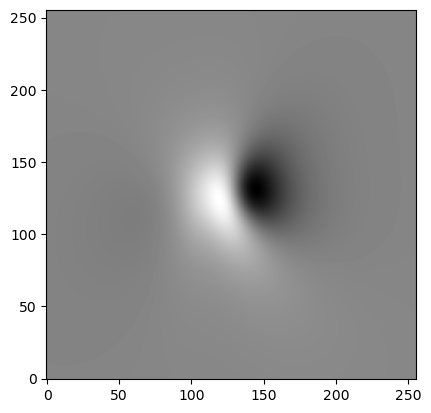

In [ ]:
b = b_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)
bz_bottom = b[:, :, 0, 2]
plt.imshow(bz_bottom.transpose(), origin='lower', cmap='gray')

<matplotlib.image.AxesImage>

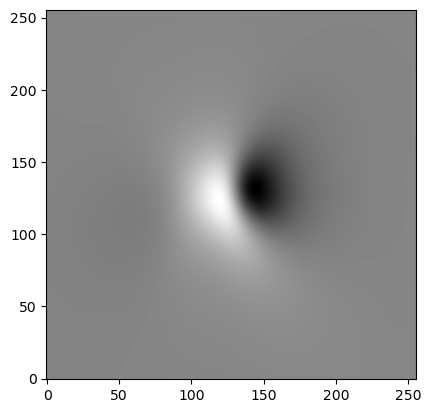

In [ ]:
B_pinn = B_pinn_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)
plt.imshow(B_pinn[:, :, 0, 2].transpose(), origin='lower', cmap='gray')

<matplotlib.image.AxesImage>

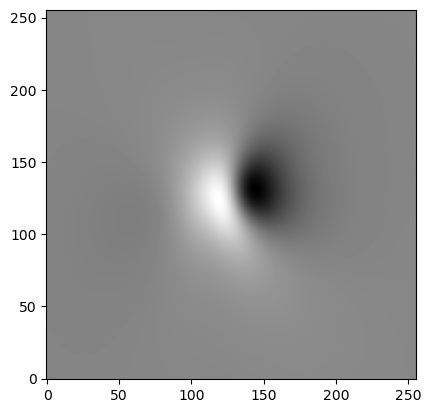

In [ ]:
B_spinn = B_spinn_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)
plt.imshow(B_spinn[:, :, 0, 2].transpose(), origin='lower', cmap='gray')

### vtk

In [ ]:
from nf2.potential.potential_field import get_potential_field
from zpinn.pinn_nf2_cleanup import create_coordinates
import numpy as np 

In [ ]:
b_pot = get_potential_field(bz_bottom, Nz)

Potential Field: 100%|██████████| 8192/8192 [03:04<00:00, 44.36it/s]


In [ ]:
Bx = b_pot[..., 0]
By = b_pot[..., 1]
Bz = b_pot[..., 2]

co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
co_coords = create_coordinates(co_bounds).reshape(-1, 3)
co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
x = co_coord[..., 0]
y = co_coord[..., 1]
z = co_coord[..., 2]
mesh = pv.StructuredGrid(x, y, z)
vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
mesh['B'] = vectors
mesh.active_vectors_name = 'B'
magnitude = np.linalg.norm(vectors, axis=-1)
mesh['mag'] = magnitude
mesh.active_scalars_name = 'mag'

mesh

StructuredGrid (0x7fea58f6e9e0)
  N Cells:      16581375
  N Points:     16777216
  X Bounds:     0.000e+00, 2.550e+02
  Y Bounds:     0.000e+00, 2.550e+02
  Z Bounds:     0.000e+00, 2.550e+02
  Dimensions:   256, 256, 256
  N Arrays:     2

In [ ]:
mesh.save(b_pot_vtk_path)

<matplotlib.image.AxesImage>

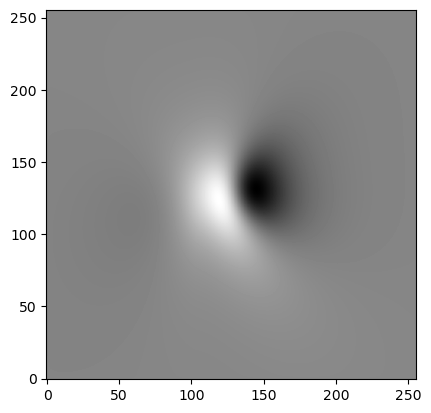

In [ ]:
b_pot = mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)
plt.imshow(b_pot[:, :, 0, 2].transpose(), origin='lower', cmap='gray')

## Viz

In [ ]:
from zpinn.pinn_nf2_visualization import draw_grid

In [ ]:
vmin = -200
vmax = 200

In [ ]:
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend('static')

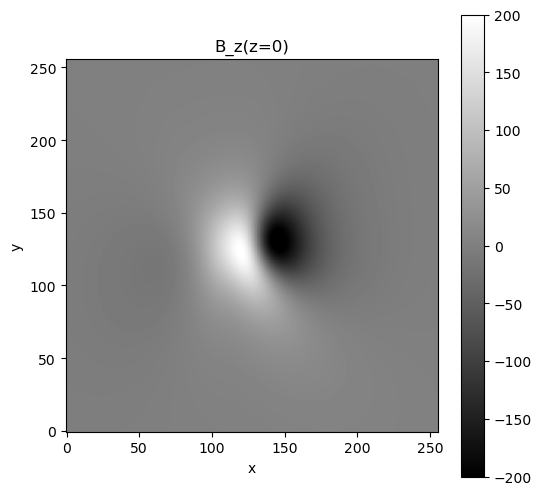

In [ ]:
draw_grid(b_mesh).plt_Bz_imshow(z=0, vmin=vmin, vmax=vmax)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


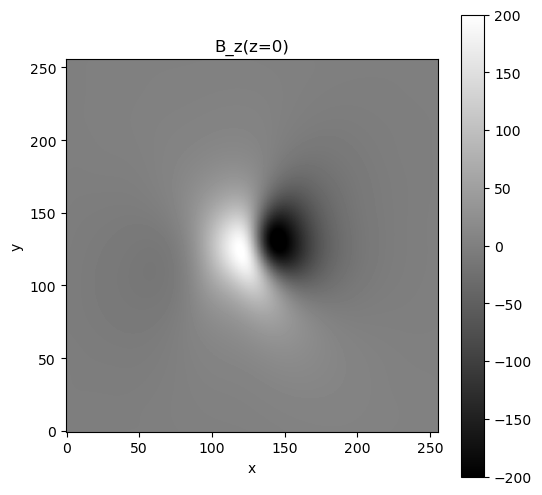

In [ ]:
draw_grid(B_pinn_mesh).plt_Bz_imshow(z=0, vmin=vmin, vmax=vmax)

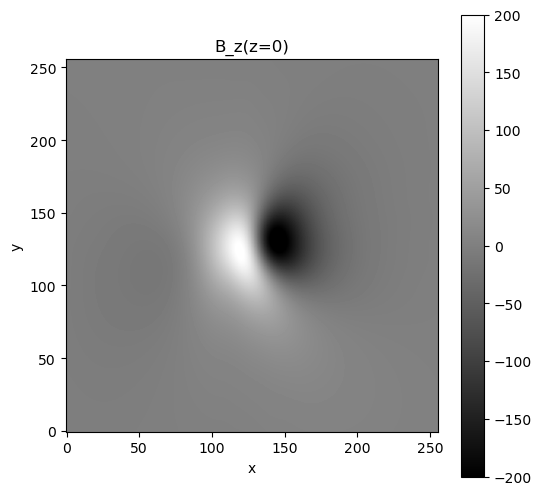

In [ ]:
draw_grid(B_spinn_mesh).plt_Bz_imshow(z=0, vmin=vmin, vmax=vmax)

In [ ]:
b_pot_mesh = pv.read(b_pot_vtk_path)

In [ ]:
b_pot_grid = draw_grid(b_pot_mesh)

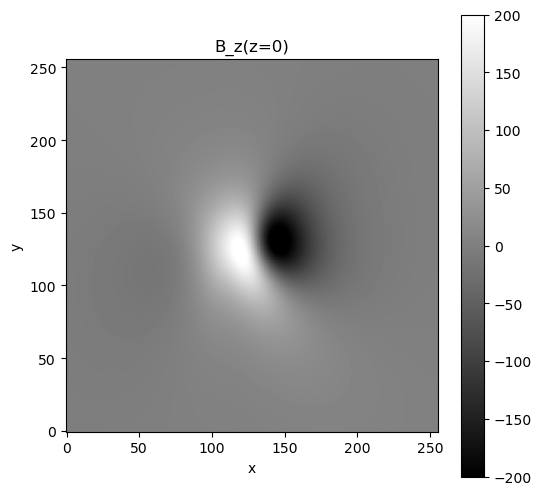

In [ ]:
b_pot_grid.plt_Bz_imshow(z=0, vmin=vmin, vmax=vmax)

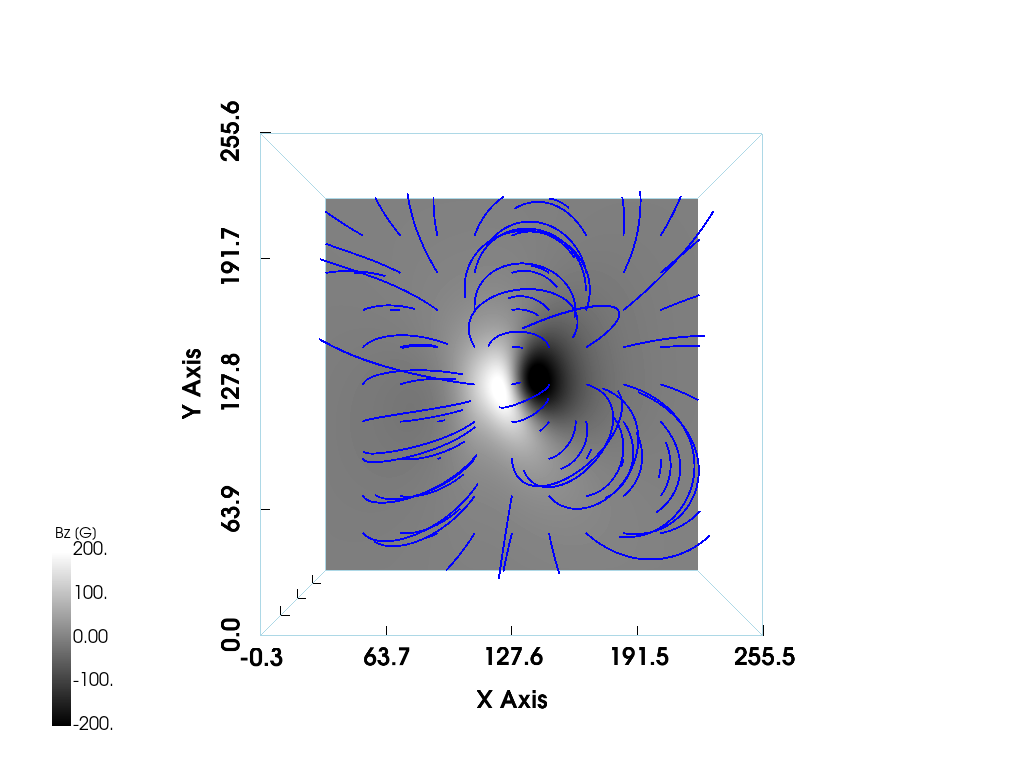

In [ ]:
b_pot_grid.pv_streamline_Bz(camera_position='xy', i_resolution=10, j_resolution=10, vmin=vmin, vmax=vmax)

## Evaluate metric

In [ ]:
import pandas as pd
from zpinn.pinn_nf2_metric import metric_df

In [ ]:
b_pot_mesh = pv.read(b_pot_vtk_path)

In [ ]:
b = b_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)
b_pot = b_pot_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)

In [ ]:
B_pinn = B_pinn_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)
B_spinn = B_spinn_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)

In [ ]:
df_b = metric_df(B=b, b=b, B_potential=b_pot, iteration='Low Lou')
df_bp = metric_df(B=b_pot, b=b, B_potential=b_pot, iteration='Potential')
df = pd.concat([df_b, df_bp], ignore_index=True)
df

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,Low Lou,1.000000,1.000000,1.000000,1.000000,1.000000,1.520778,0.167453,5.518802e-03,0.01451,1.000000
1,Potential,0.870132,0.836411,0.445706,0.351677,0.657558,1.000000,0.828358,2.528034e-12,0.04455,0.000001


In [ ]:
df_new = metric_df(B=B_pinn, b=b, B_potential=b_pot, iteration=f'pinn [{total_iter}]')
df = pd.concat([df, df_new], ignore_index=True)
df

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,Low Lou,1.000000,1.000000,1.000000,1.000000,1.000000,1.520778,0.167453,5.518802e-03,0.014510,1.000000
1,Potential,0.870132,0.836411,0.445706,0.351677,0.657558,1.000000,0.828358,2.528034e-12,0.044550,0.000001
2,pinn [10000],0.971726,0.533345,0.563112,0.050422,0.890078,1.353611,0.526349,1.748676e-02,0.012495,1.502887


In [ ]:
df_new = metric_df(B=B_spinn, b=b, B_potential=b_pot, iteration=f'spinn [{total_iter}]')
df = pd.concat([df, df_new], ignore_index=True)
df

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,Low Lou,1.000000,1.000000,1.000000,1.000000,1.000000,1.520778,0.167453,5.518802e-03,0.014510,1.000000
1,Potential,0.870132,0.836411,0.445706,0.351677,0.657558,1.000000,0.828358,2.528034e-12,0.044550,0.000001
2,pinn [10000],0.971726,0.533345,0.563112,0.050422,0.890078,1.353611,0.526349,1.748676e-02,0.012495,1.502887
3,spinn [10000],0.990873,0.929470,0.742338,0.518280,0.853333,1.297730,0.046119,4.695434e-05,0.000015,0.824684


## Multi metric

In [ ]:
from setproctitle import setproctitle

setproctitle("LowLou metric")

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [ ]:
import numpy as np
import pandas as pd
import pyvista as pv

In [ ]:
b_vtk_path = '01_input/lowlou_256256256/b.vtk'
b_mesh = pv.read(b_vtk_path)
Nx, Ny, Nz = b_mesh.dimensions
b = b_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)

In [ ]:
b_pot_vtk_path = '01_input/lowlou_256256256/b_pot.vtk'
b_pot_mesh = pv.read(b_pot_vtk_path)
b_pot = b_pot_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)

In [ ]:
from zpinn.pinn_nf2_metric import metric_df

In [ ]:
df_b = metric_df(B=b, b=b, B_potential=b_pot, iteration='Low Lou')
df_bp = metric_df(B=b_pot, b=b, B_potential=b_pot, iteration='Potential')
df = pd.concat([df_b, df_bp], ignore_index=True)
df

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,Low Lou,1.000000,1.000000,1.000000,1.000000,1.000000,1.520778,0.167453,5.518802e-03,0.01451,1.000000
1,Potential,0.870132,0.836411,0.445706,0.351677,0.657558,1.000000,0.828358,2.528034e-12,0.04455,0.000001


In [ ]:
df_pinn = df.copy()
df_spinn = df.copy()

In [ ]:
iterations = np.arange(0, 10001, 1000)

for epo in iterations:
    output_path = '02_output/lowlou_256256256'
    eval_path = '03_eval/lowlou_256256256'

    B_pinn_vtk_path = os.path.join(eval_path, f'PINN/B_pinn_{epo}.vtk')
    B_pinn_mesh = pv.read(B_pinn_vtk_path)
    B_pinn = B_pinn_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)

    df_new_pinn = metric_df(B=B_pinn, b=b, B_potential=b_pot, iteration=epo)
    df_pinn = pd.concat([df_pinn, df_new_pinn], ignore_index=True)

    B_spinn_vtk_path = os.path.join(eval_path, f'SPINN/B_spinn_{epo}.vtk')
    B_spinn_mesh = pv.read(B_spinn_vtk_path)
    B_spinn = B_spinn_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)

    df_new_spinn = metric_df(B=B_spinn, b=b, B_potential=b_pot, iteration=epo)
    df_spinn = pd.concat([df_spinn, df_new_spinn], ignore_index=True)

/userhome/jeon_mg/workspace/zpinn/zpinn/pinn_nf2_metric.py:39: RuntimeWarning: invalid value encountered in divide
  c_cs = (1 / M) * np.sum((B * b).sum(-1) / (vector_norm(B)*vector_norm(b)))
/userhome/jeon_mg/workspace/zpinn/zpinn/pinn_nf2_metric.py:50: RuntimeWarning: invalid value encountered in divide
  sig_J = (vector_norm(np.cross(j, B, -1)) / vector_norm(B)).sum() / vector_norm(j).sum()
/userhome/jeon_mg/workspace/zpinn/zpinn/pinn_nf2_metric.py:51: RuntimeWarning: invalid value encountered in divide
  L1 = (vector_norm(np.cross(j, B, -1)) ** 2 / vector_norm(B) ** 2).mean()


In [ ]:
df_pinn

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,Low Lou,1.000000,1.000000,1.000000,1.000000,1.000000,1.520778,0.167453,5.518802e-03,0.014510,1.000000
1,Potential,0.870132,0.836411,0.445706,0.351677,0.657558,1.000000,0.828358,2.528034e-12,0.044550,0.000001
2,0,-0.097569,-0.308612,-0.687480,-2.868442,0.174027,0.264656,0.740813,1.036920e-04,0.000023,0.135179
3,1000,0.634725,-0.007456,-1.842383,-7.273778,5.315382,8.083516,0.766604,8.483876e-01,0.921833,6.566581
4,2000,0.725301,0.005830,-0.873671,-3.125464,2.720246,4.136890,0.717694,3.675022e-01,0.391824,4.496687
5,3000,0.709135,0.126051,-0.698017,-2.563208,1.918345,2.917376,0.718237,1.674418e-01,0.154570,3.810336
6,4000,0.799242,0.149019,-0.186319,-1.635387,1.191748,1.812384,0.732743,1.179569e-01,0.081820,3.193156
7,5000,0.900571,0.455760,0.193029,-0.827454,1.054381,1.603479,0.670696,8.029521e-02,0.050125,2.652863
8,6000,0.886150,0.175970,0.106863,-1.081056,0.946977,1.440142,0.696627,5.985541e-02,0.036978,2.256512
9,7000,0.948347,0.464559,0.445989,-0.183769,0.865656,1.316471,0.605367,3.987574e-02,0.025952,1.927844


In [ ]:
df_spinn

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,Low Lou,1.000000,1.000000,1.000000,1.000000,1.000000,1.520778,0.167453,5.518802e-03,0.014510,1.000000
1,Potential,0.870132,0.836411,0.445706,0.351677,0.657558,1.000000,0.828358,2.528034e-12,0.044550,0.000001
2,0,0.029014,NaN,-0.059402,-0.437256,0.013704,0.020841,NaN,NaN,0.000016,0.138345
3,1000,0.989196,0.925791,0.732603,0.522143,0.827736,1.258803,0.141401,3.914384e-04,0.000179,0.843624
4,2000,0.990783,0.930001,0.748154,0.547816,0.841227,1.279319,0.085072,1.328859e-04,0.000062,0.839675
5,3000,0.991185,0.929403,0.748128,0.534306,0.845399,1.285664,0.071732,9.039875e-05,0.000035,0.836924
6,4000,0.991174,0.936536,0.751032,0.543021,0.850963,1.294126,0.069026,1.335146e-04,0.000037,0.839336
7,5000,0.991045,0.931330,0.744679,0.530348,0.844131,1.283736,0.062656,8.164142e-05,0.000022,0.830797
8,6000,0.990957,0.933413,0.745478,0.526103,0.854432,1.299402,0.050401,5.220777e-05,0.000021,0.828511
9,7000,0.991344,0.926863,0.744426,0.520589,0.841939,1.280402,0.075043,1.433668e-04,0.000114,0.839115


In [ ]:
df_pinn.to_csv('03_eval/lowlou_256256256/metric_pinn.csv', index=False)
df_spinn.to_csv('03_eval/lowlou_256256256/metric_spinn.csv', index=False)

In [ ]:
# df

,iteration,C_vec,C_cs,1-En,1-Em,eps,eps_p,sig_J,L1,L2,curlB
0,Low Lou,1.000000,1.000000,1.000000,1.000000,1.000000,1.520778,0.167453,5.518802e-03,0.014510,1.000000
1,Potential,0.870132,0.836411,0.445706,0.351677,0.657558,1.000000,0.828358,2.528034e-12,0.044550,0.000001
2,PINN [1000],0.634725,-0.007456,-1.842383,-7.273778,5.315382,8.083516,0.766604,8.483876e-01,0.921833,6.566581
3,SPINN [1000],0.989196,0.925791,0.732603,0.522143,0.827736,1.258803,0.141401,3.914384e-04,0.000179,0.843624
4,PINN [2000],0.725301,0.005830,-0.873671,-3.125464,2.720246,4.136890,0.717694,3.675022e-01,0.391824,4.496687
5,SPINN [2000],0.990783,0.930001,0.748154,0.547816,0.841227,1.279319,0.085072,1.328859e-04,0.000062,0.839675
6,PINN [3000],0.709135,0.126051,-0.698017,-2.563208,1.918345,2.917376,0.718237,1.674418e-01,0.154570,3.810336
7,SPINN [3000],0.991185,0.929403,0.748128,0.534306,0.845399,1.285664,0.071732,9.039875e-05,0.000035,0.836924
8,PINN [4000],0.799242,0.149019,-0.186319,-1.635387,1.191748,1.812384,0.732743,1.179569e-01,0.081820,3.193156
9,SPINN [4000],0.991174,0.936536,0.751032,0.543021,0.850963,1.294126,0.069026,1.335146e-04,0.000037,0.839336


In [ ]:
# df.to_csv('03_eval/lowlou_256256256/metric.csv', index=False)